In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt

In [3]:
plt.style.use("ggplot")

In [4]:
from pennylane import numpy as np
import pennylane as qml

In [5]:
from sklearn.datasets import make_circles, make_moons

# Quantum Feature Maps with PennyLane

Re-implementation of the [Analysis and synthesis of feature map for kernel-based quantum classifier](https://arxiv.org/abs/1906.10467)

## Main idea of feature map

We want to translate our original space $\mathbf{R}^N$ to $\mathbf{C}^{2^N}$ Hilbert space. Main idea is to make non-separable points in the original space separable in the new space. This idea is very close to kernel-trick in classical SVM.

Here are two examples of non-separable data:

### Circles

In [6]:
circles_points, circles_y = make_circles()

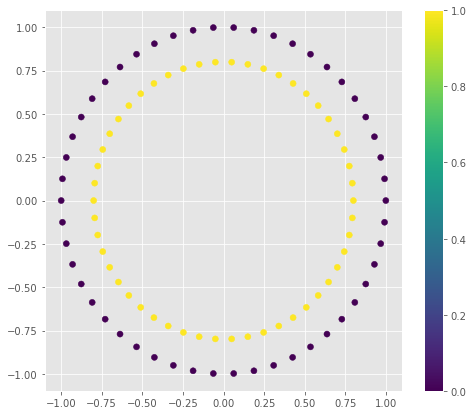

In [7]:
f = plt.figure(figsize=(8, 7))
clr = plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_y)
plt.colorbar(clr)
f.show()

### XOR

In [8]:
xor_points = np.c_[
    np.c_[np.random.normal(-0.7, 0.05, 20), np.random.normal(-0.7, 0.05, 20)].T,
    np.c_[np.random.normal(0.7, 0.05, 20), np.random.normal(0.7, 0.05, 20)].T,
    np.c_[np.random.normal(-0.7, 0.05, 20), np.random.normal(0.7, 0.05, 20)].T,
    np.c_[np.random.normal(0.7, 0.05, 20), np.random.normal(-0.7, 0.05, 20)].T
].T
xor_y = np.c_[np.zeros(40), np.ones(40)].T

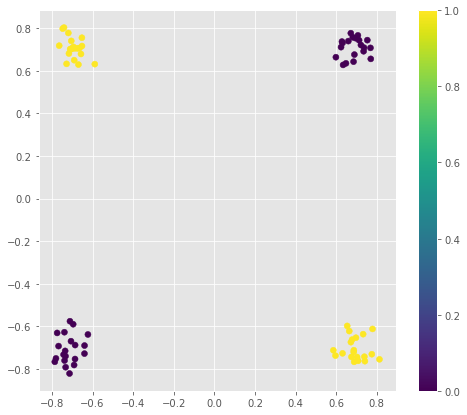

In [9]:
f = plt.figure(figsize=(8, 7))
clr = plt.scatter(xor_points[:, 0], xor_points[:, 1], c=xor_y)
plt.colorbar(clr)
f.show()

## 2d order Quantum Feature Map

Second order Quantum Feature Map $U_{\Phi(\mathbf{X})}$ contains three operators $U1_{\phi(x_1)}$, $U1_{\phi(x_2)}$, $U1_{\phi(x_1, x_2)}$ mixed with Hadamard gates and CNOT gates.

Here $U1$ is a phase shifting gate:

$$U1_\phi = \begin{bmatrix}1 & 0\\ 0 & e^{i\phi}\end{bmatrix}$$

And function phi is the following:
$$\phi = \begin{cases} \phi(x_{1, 2}) = x_{1, 2}\\ \phi(x_1, x_2) = \pi x_1x_2\end{cases}$$

At first we will measure the value of $\sigma^z\sigma^z$ operator:
$$\sigma^z\sigma^z = \mathbf{Z}\mathbf{Z} = \begin{bmatrix}1 & 0\\0 & -1\end{bmatrix} \bigotimes \begin{bmatrix}1 & 0\\0 & -1\end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0\\ 0 & 0 & 0 & 1\end{bmatrix}$$

### Implementation in PennyLane

In [10]:
dev = qml.device("default.qubit", 2)

In [11]:
@qml.qnode(dev)
def simplest_feature_map(x1, x2):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    qml.U1(x1, wires=0)
    qml.U1(x2, wires=1)
    
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    qml.CNOT(wires=[0, 1])
    qml.U1(np.pi * x1 * x2, wires=1)
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

### Transformation of random points

In [12]:
random_points = np.random.uniform(-1, 1, size=(3000, 2))

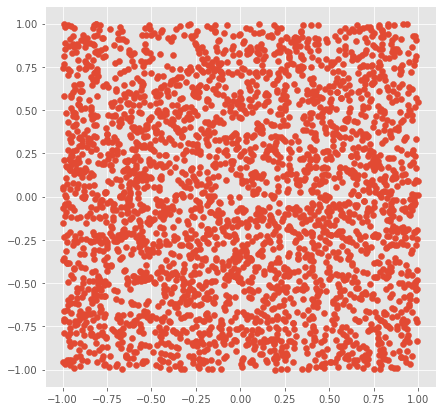

In [13]:
f = plt.figure(figsize=(7, 7))
plt.scatter(random_points[:, 0], random_points[:, 1])
f.show()

In [74]:
zz_proj = [simplest_feature_map(x1, x2) for x1, x2 in random_points]

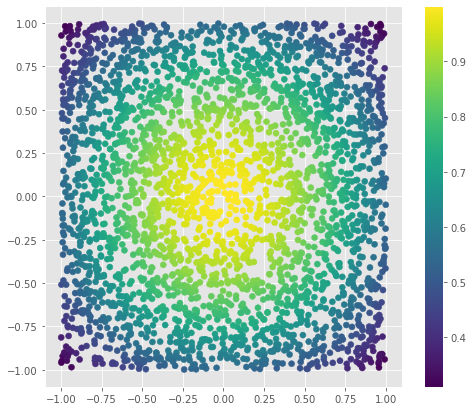

In [75]:
f = plt.figure(figsize=(8, 7))
clbr = plt.scatter(random_points[:, 0], random_points[:, 1], c=zz_proj)
plt.colorbar(clbr)
f.show()

### Circuit

In [77]:
print(simplest_feature_map.draw())

 0: ──H──Rϕ(-0.817)──H──╭C─────────────╭C──╭┤ ⟨Z ⊗ Z⟩ 
 1: ──H──Rϕ(0.917)───H──╰X──Rϕ(-2.35)──╰X──╰┤ ⟨Z ⊗ Z⟩ 



### Solution of circles problem 

We can separate circles problem with $\mathbf{Z}\mathbf{Z}$ simplest feature map.

In [94]:
circles_proj_zz = [simplest_feature_map(x1, x2) for x1, x2 in circles_points]

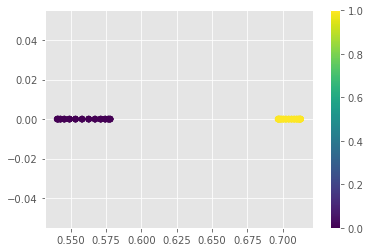

In [96]:
f = plt.figure()
clbr = plt.scatter(circles_proj_zz, np.zeros_like(circles_proj_zz), c=circles_y)
plt.colorbar(clbr)
f.show()

We can see that all the points with value of $\mathbf{Z}\mathbf{Z}$ projection less than $0.6$ have class $\mathbf{0}$ and all the points with projection value greater than $0.675$ have class $\mathbf{1}$

### YY-projection

In [97]:
@qml.qnode(dev)
def simplest_feature_map_yy(x1, x2):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    qml.U1(x1, wires=0)
    qml.U1(x2, wires=1)
    
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    qml.CNOT(wires=[0, 1])
    qml.U1(np.pi * x1 * x2, wires=1)
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliY(0) @ qml.PauliY(1))

In [98]:
yy_proj = [simplest_feature_map_yy(x1, x2) for x1, x2 in random_points]

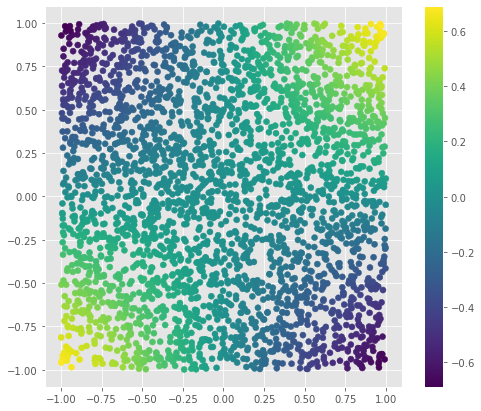

In [99]:
f = plt.figure(figsize=(8, 7))
clbr = plt.scatter(random_points[:, 0], random_points[:, 1], c=yy_proj)
plt.colorbar(clbr)
f.show()

### Solution of XOR problem

In [100]:
xor_proj_yy = [simplest_feature_map_yy(x1, x2) for x1, x2 in xor_points]

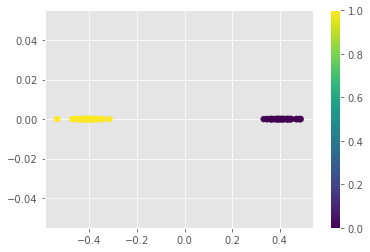

In [101]:
f = plt.figure()
clbr = plt.scatter(xor_proj_yy, np.zeros_like(xor_proj_yy), c=xor_y)
plt.colorbar(clbr)
f.show()

We can see that all the points with value of $\mathbf{Y}\mathbf{Y}$ projection less than $-0.2$ have class $\mathbf{0}$ and all the points with projection value greater than $0.2$ have class $\mathbf{1}$